# Etape 2 : Préparation des données pour notre algorithme de machine learning et Modélisation

In [26]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures,RobustScaler
from math import sqrt
from sklearn.compose import make_column_selector,make_column_transformer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pickle5 as pickle
from sklearn.model_selection import learning_curve

In [27]:
df = pd.read_csv('cleaned.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1332,50,male,30.97,3,no,northwest,10600.55
1333,18,female,31.92,0,no,northeast,2205.98
1334,18,female,36.85,0,no,southeast,1629.83
1335,21,female,25.80,0,no,southwest,2007.94


## I) Préparation du modèle pour le Machine Learning

#### Introduction : Dans l'étape 1, on a séparer nos variables en deux catégories : quantitatives et catégorielles. Après avoir catégoriser ses variables,on va les transformer  pour qu'elles soient ajuster à notre modèle. 

#### One-Hot-Encoding  :  Pour transformer nos variables catégorielles on va utilise le one-hot encoding , on va convertir les valeurs associées à nos variables en de nouvelles colonnes de variables et on leur assigne une valeur binaire 1 pour présent et 0 pour non existant.

In [28]:
categorical_features = ['sex','smoker']

In [29]:
df[categorical_features] = df[categorical_features].astype('string')

#### Scaling : Pour les variables quantitatives, on utilise des méthodes de scaling telle que la normalisation,standardization lorsqu'une des variables aura un poids plus élevé sur les autres.

In [30]:
numerical_features = ['age','bmi','children']

### 1. La magie des Pipelines

#### Une pipeline est une chaine de transformation ,elle va nous permettre de faire plusieurs action de transformation sur nos données.On a au préalables séparer nos variables en deux catégories les valeurs numériques et catégoriques, on va ainsi pouvoir créer deux pipelines. Ici notre target est les charges de l'assurance en fonction des autres paramètres.

In [36]:

preprocessor = ColumnTransformer([
    ("one_hot", OneHotEncoder(handle_unknown='ignore'),categorical_features),
    ("scaling", RobustScaler(), numerical_features)
])


## II) Modélisation

#### Après avoir créer notre premier transformeur composé des deux pipelines (OneHotEncoding,Standardisation), nous allons maintenant nous attaqué aux différents types de régression linéaire pour ajuster notre modèle.

In [37]:
X = df.drop(['charges','region'], axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42)

## 1) Les algorithmes de Régression

### A) La Régression Linéaire

In [38]:
lr_pipeline = make_pipeline(preprocessor,PolynomialFeatures(),LinearRegression())
lr_pipeline.fit(X_train,y_train)
lr_pipeline.score(X_test,y_test)


0.8808979265249346

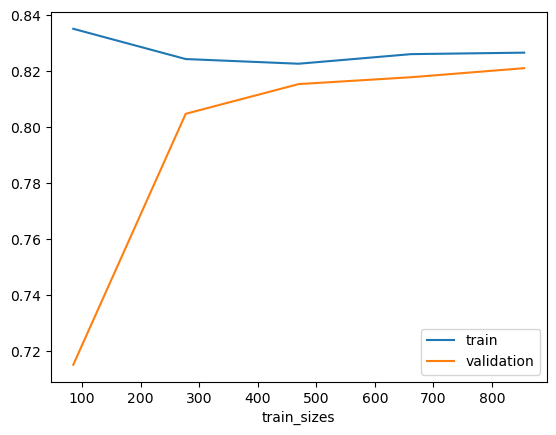

In [39]:
x =learning_curve(lr_pipeline,X_train,y_train,return_times=True)


plt.plot(x[0], x[1].mean(axis=1), label='train')
plt.plot(x[0], x[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### B) Le Lasso Régression

In [42]:
lasso_pipeline = make_pipeline(preprocessor,PolynomialFeatures(),Lasso(alpha=0.54,random_state=42,))
lasso_pipeline.fit(X_train,y_train)
lasso_pipeline.score(X_test,y_test)


0.8826574001637827

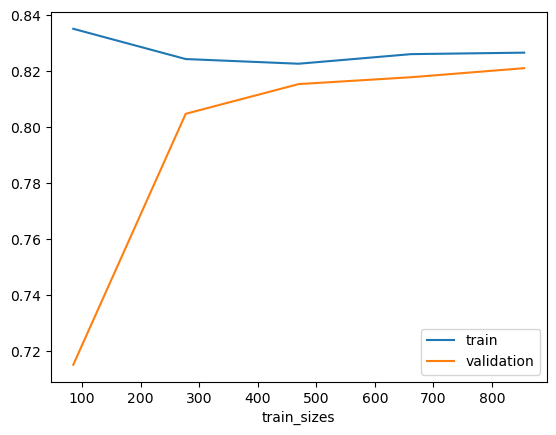

In [43]:
z =learning_curve(lr_pipeline,X_train,y_train,return_times=True)

plt.plot(z[0], z[1].mean(axis=1), label='train')
plt.plot(z[0], z[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

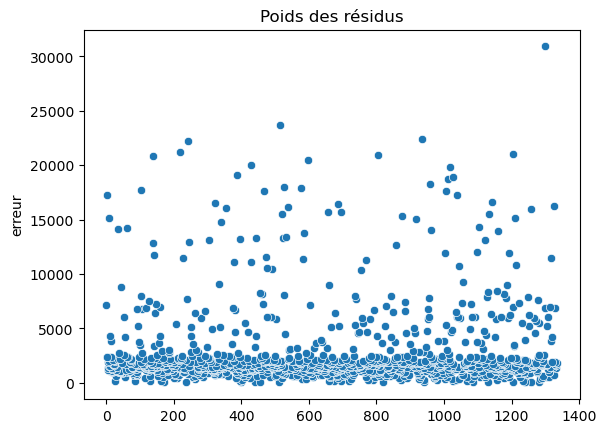

In [44]:
lasso_pred = lasso_pipeline.predict(X_train)
residual_lasso = (y_train - lasso_pred).abs().sort_values()
sns.scatterplot( residual_lasso)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()


In [45]:
lasso_indice = residual_lasso[residual_lasso > 15000].index
lasso_indice

Int64Index([ 916,    9, 1210,  875, 1133,  520,  657,  695, 1257,  355,  539,
            1327,  687,  321, 1141,    3, 1038,  468, 1007,  102,  577,  526,
             958, 1011, 1026,  387, 1018,  430,  598,  140,  805, 1205,  219,
             242,  935,  516, 1299],
           dtype='int64')

In [46]:
X_train_cleaned = X_train.drop(lasso_indice)
y_train_cleaned = y_train.drop(lasso_indice)

#### B.2) A la Recherche d'un meilleur alpha

In [47]:
lasso_alphas={"lasso__alpha":np.arange(53,57.00,0.01)}
model_lasso = GridSearchCV(estimator = lasso_pipeline,cv=5,scoring="r2",param_grid=lasso_alphas)
model_lasso.fit(X_train_cleaned,y_train_cleaned)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'smoker']),
                                                                        ('scaling',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('lasso',
                                        Lasso(alpha=0.54, random_state=42))]),
             param_grid={'lasso__alpha': array([53.  , 53...
       56.42, 56.43, 56.44, 56.45, 56.46, 56.47, 56.48, 56.49, 56.5 ,
       56.51, 56.52, 56.53, 56.54, 56.55, 56.56, 56.57, 56.58, 56.59,
       56.6 , 56.61, 56.62, 56.63, 56.64, 56.65, 56.66, 56.67, 56.68,
       56.69, 56.7 , 56.71, 56.72, 56.73, 56.74, 56.75, 56.76, 56.77,
       56.78, 56.79, 56.8 , 56.81, 56.82, 56.83, 56.84, 56.85, 56.86,
       56.87, 56.88, 56.89, 56.9 , 56.91, 56.92, 56.93, 56.94, 56.95,
       56.96, 56.97, 56.98, 56.99])},
             scoring='r2')

In [48]:
model_lasso.best_params_

{'lasso__alpha': 53.0}

In [49]:
bl_alpha=model_lasso.best_params_['lasso__alpha']
bl_alpha

53.0

##### Test avec le nouveau alpha

In [57]:
lasso_pipeline = make_pipeline(preprocessor,PolynomialFeatures(),Lasso(random_state=42,alpha=bl_alpha))
lasso_pipeline.fit(X_train_cleaned,y_train_cleaned)
lasso_pipeline.score(X_test,y_test)


0.8820590484624176

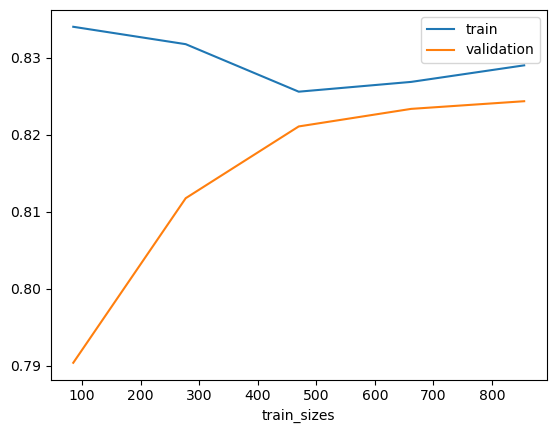

In [51]:
x =learning_curve(lasso_pipeline,X_train,y_train,return_times=True)
plt.plot(x[0], x[1].mean(axis=1), label='train')
plt.plot(x[0], x[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### C)Le Ridge Regression

In [52]:

R_pipeline = make_pipeline(preprocessor,PolynomialFeatures(),Ridge(alpha=54,random_state=42))
R_pipeline.fit(X_train,y_train)
R_pipeline.score(X_test,y_test)


0.8700833417234872

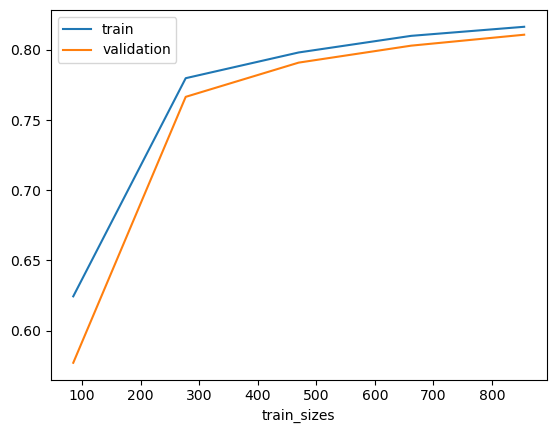

In [53]:
y =learning_curve(R_pipeline,X_train,y_train,return_times=True)


plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### D) Elastic Regression

In [54]:
eN_pipeline= make_pipeline(preprocessor,PolynomialFeatures(),ElasticNet(alpha=0.0001))
eN_pipeline.fit(X_train,y_train)
eN_pipeline.score(X_test, y_test)

/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+10, tolerance: 1.464e+07
  model = cd_fast.enet_coordinate_descent(


0.8826467741891417

/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.714e+08, tolerance: 1.006e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e+09, tolerance: 4.034e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

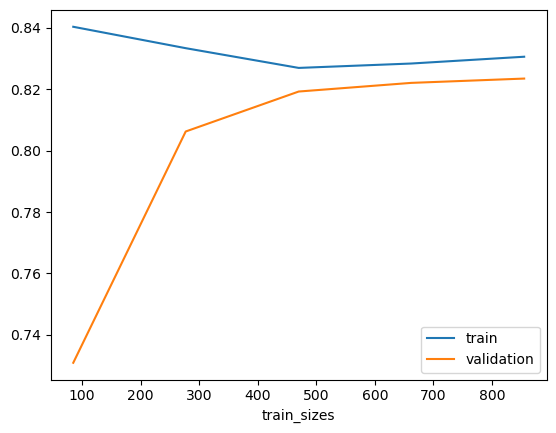

In [55]:
w =learning_curve(eN_pipeline,X_train,y_train,return_times=True)
plt.plot(w[0], w[1].mean(axis=1), label='train')
plt.plot(w[0], w[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# III) Exportation du modèle vers Streamlit

In [56]:
pickle_out = open("modellr.pkl", "wb") 
pickle.dump(lr_pipeline, pickle_out) 
pickle_out.close()
pickle_out2 = open("modelRid.pkl", "wb") 
pickle.dump(R_pipeline, pickle_out2) 
pickle_out2.close()
pickle_out3 = open("modelLasso.pkl", "wb") 
pickle.dump(lasso_pipeline, pickle_out3) 
pickle_out3.close()
pickle_out4 = open("modelEN.pkl", "wb") 
pickle.dump(eN_pipeline, pickle_out4) 
pickle_out4.close()
